<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Higgs_Boson_Physics_Informed_MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download the dataset (2.6GB)
!wget -O HIGGS.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz


--2025-06-10 18:19:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [               <=>  ]   2.62G  23.7MB/s    in 2m 17s  

2025-06-10 18:22:14 (19.6 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



In [ ]:
# Unzip (will take a few minutes and ~7.5GB disk)
!gunzip HIGGS.csv.gz

gzip: HIGGS.csv already exists; do you wish to overwrite (y or n)? y


In [12]:
CSV_PATH = 'HIGGS.csv'
N_TRAIN = 500_000         # Use more data for training
N_META_TEST = 50_000      # More meta-test tasks
# If you add physics features, update N_FEATURES accordingly (e.g., 40)
N_FEATURES = 40           # 28 + 5 (log) + 5 (sqrt) + 1 (product) + 1 (ratio)
HIDDEN_SIZE = 512         # Wider model
N_CLASSES = 2

# Meta-learning hyperparameters
META_TRAIN_TASKS = 100    # More meta-tasks per epoch
META_TEST_TASKS = 20      # More meta-test tasks for evaluation
META_INNER_STEPS = 10     # More inner-loop adaptation steps
META_INNER_LR = 0.05      # Slightly lower inner-loop LR for stability
META_OUTER_LR = 0.0005    # Lower outer-loop LR for stable meta-learning
META_SUPPORT = 512        # Larger support set per meta-task
META_QUERY = 2048         # Larger query set per meta-task
N_EPOCHS = 20             # More meta-training epochs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt

In [13]:
class HiggsDataset(Dataset):
    def __init__(self, csv_path, n_samples=None, offset=0, add_physics_features=True):
        df = pd.read_csv(csv_path, header=None, nrows=n_samples, skiprows=range(1, offset+1))
        X = df.iloc[:, 1:].values.astype(np.float32)
        if add_physics_features:
            # Example: add log, sqrt, and pairwise products of first 5 features
            X = np.concatenate([
                X,
                np.log1p(np.abs(X[:, :5])),
                np.sqrt(np.abs(X[:, :5])),
                X[:, [0]] * X[:, [1]],  # product of feature 0 and 1
                X[:, [2]] / (X[:, [3]] + 1e-6)  # ratio of feature 2 and 3
            ], axis=1)
        self.X = X
        self.y = df.iloc[:, 0].values.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

In [14]:
class PhysicsMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=5, activation='gelu', dropout=0.3):
        super().__init__()
        act = {
            'leakyrelu': nn.LeakyReLU(),
            'elu': nn.ELU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU()
        }[activation]
        layers = [nn.BatchNorm1d(input_dim)]
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(act)
            layers.append(nn.LayerNorm(hidden_dim))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [ ]:
def plot_metrics(history, title="Training/Validation Metrics"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.title('Meta-Train Loss')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.title('Meta-Train Accuracy')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_f1'], label='Train')
    plt.title('Meta-Train F1')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_roc'], label='Train')
    plt.title('Meta-Train ROC-AUC')
    plt.legend()
    plt.suptitle(title)
    plt.show()

In [15]:
def maml_meta_train(dataset, n_tasks, support_size, query_size, n_inner, inner_lr, outer_lr, n_epochs, device):
    model = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=6, activation='gelu', dropout=0.4).to(device)
    outer_opt = optim.Adam(model.parameters(), lr=outer_lr)
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_roc': []}

    for epoch in range(n_epochs):
        model.train()
        meta_loss = 0
        meta_accs, meta_f1s, meta_rocs = [], [], []
        for _ in range(n_tasks):
            idx = np.random.choice(len(dataset), support_size + query_size, replace=False)
            support_idx, query_idx = idx[:support_size], idx[support_size:]
            X_s = torch.stack([dataset[i][0] for i in support_idx]).to(device)
            y_s = torch.tensor([dataset[i][1] for i in support_idx]).to(device)
            X_q = torch.stack([dataset[i][0] for i in query_idx]).to(device)
            y_q = torch.tensor([dataset[i][1] for i in query_idx]).to(device)

            # Clone model for inner loop
            fast_weights = [p.clone() for p in model.parameters()]
            for _ in range(n_inner):
                logits = model(X_s)
                loss = nn.CrossEntropyLoss()(logits, y_s)
                grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
                fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
                for p, w in zip(model.parameters(), fast_weights):
                    p.data = w.data

            logits_q = model(X_q)
            loss_q = nn.CrossEntropyLoss()(logits_q, y_q)
            meta_loss += loss_q
            preds_q = torch.argmax(logits_q, dim=1).cpu().numpy()
            y_q_np = y_q.cpu().numpy()
            probs_q = torch.softmax(logits_q, dim=1)[:, 1].detach().cpu().numpy()
            meta_accs.append(accuracy_score(y_q_np, preds_q))
            meta_f1s.append(precision_recall_fscore_support(y_q_np, preds_q, average='binary', zero_division=0)[2])
            try:
                meta_rocs.append(roc_auc_score(y_q_np, probs_q))
            except:
                meta_rocs.append(float('nan'))

        meta_loss = meta_loss / n_tasks
        outer_opt.zero_grad()
        meta_loss.backward()
        outer_opt.step()

        history['train_loss'].append(meta_loss.item())
        history['train_acc'].append(np.mean(meta_accs))
        history['train_f1'].append(np.mean(meta_f1s))
        history['train_roc'].append(np.nanmean(meta_rocs))

        print(f"Epoch {epoch+1}: Loss {meta_loss.item():.4f}, Acc {np.mean(meta_accs):.4f}, F1 {np.mean(meta_f1s):.4f}, ROC {np.nanmean(meta_rocs):.4f}")

    return model, history

In [17]:
def meta_adaptation_curve(model, dataset, support_size, query_size, n_steps, inner_lr, device, n_tasks=5):
    accs_all, f1s_all, rocs_all = [], [], []
    for task in range(n_tasks):
        idx = np.random.choice(len(dataset), support_size + query_size, replace=False)
        support_idx, query_idx = idx[:support_size], idx[support_size:]
        X_s = torch.stack([dataset[i][0] for i in support_idx]).to(device)
        y_s = torch.tensor([dataset[i][1] for i in support_idx]).to(device)
        X_q = torch.stack([dataset[i][0] for i in query_idx]).to(device)
        y_q = torch.tensor([dataset[i][1] for i in query_idx]).to(device)

        adapted = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=6, activation='gelu', dropout=0.4).to(device)
        adapted.load_state_dict(model.state_dict())
        accs, f1s, rocs = [], [], []

        for step in range(n_steps + 1):
            with torch.no_grad():
                logits_q = adapted(X_q)
                preds_q = torch.argmax(logits_q, dim=1).cpu().numpy()
                y_q_np = y_q.cpu().numpy()
                probs_q = torch.softmax(logits_q, dim=1)[:, 1].detach().cpu().numpy()
                accs.append(accuracy_score(y_q_np, preds_q))
                f1s.append(precision_recall_fscore_support(y_q_np, preds_q, average='binary', zero_division=0)[2])
                try:
                    rocs.append(roc_auc_score(y_q_np, probs_q))
                except:
                    rocs.append(float('nan'))
            if step < n_steps:
                logits_s = adapted(X_s)
                loss_s = nn.CrossEntropyLoss()(logits_s, y_s)
                grads = torch.autograd.grad(loss_s, adapted.parameters())
                for p, g in zip(adapted.parameters(), grads):
                    p.data -= inner_lr * g
        accs_all.append(accs)
        f1s_all.append(f1s)
        rocs_all.append(rocs)

    # Plot average adaptation curve
    steps = range(n_steps + 1)
    plt.figure(figsize=(10, 4))
    plt.plot(steps, np.mean(accs_all, axis=0), label='Accuracy')
    plt.plot(steps, np.mean(f1s_all, axis=0), label='F1')
    plt.plot(steps, np.mean(rocs_all, axis=0), label='ROC-AUC')
    plt.xlabel('Adaptation Step')
    plt.ylabel('Metric')
    plt.title('Meta-Test Adaptation Curve (Averaged)')
    plt.legend()
    plt.show()

    print(f"Meta-test final accuracy: {np.mean([a[-1] for a in accs_all]):.4f}")
    print(f"Meta-test final F1: {np.mean([f[-1] for f in f1s_all]):.4f}")
    print(f"Meta-test final ROC-AUC: {np.mean([r[-1] for r in rocs_all]):.4f}")

Using device: cuda
Loading data...
Meta-training...
Epoch 1: Loss 0.6661, Acc 0.6007, F1 0.6410, ROC 0.6365
Epoch 2: Loss 0.6334, Acc 0.6494, F1 0.6767, ROC 0.6994
Epoch 3: Loss 0.6176, Acc 0.6664, F1 0.6900, ROC 0.7227
Epoch 4: Loss 0.6075, Acc 0.6739, F1 0.6927, ROC 0.7351
Epoch 5: Loss 0.6019, Acc 0.6792, F1 0.6952, ROC 0.7426
Epoch 6: Loss 0.5955, Acc 0.6831, F1 0.6996, ROC 0.7503
Epoch 7: Loss 0.5883, Acc 0.6883, F1 0.7051, ROC 0.7574
Epoch 8: Loss 0.5836, Acc 0.6906, F1 0.7100, ROC 0.7619
Epoch 9: Loss 0.5817, Acc 0.6938, F1 0.7081, ROC 0.7654
Epoch 10: Loss 0.5803, Acc 0.6936, F1 0.7121, ROC 0.7657
Epoch 11: Loss 0.5777, Acc 0.6953, F1 0.7119, ROC 0.7689
Epoch 12: Loss 0.5739, Acc 0.6995, F1 0.7150, ROC 0.7728
Epoch 13: Loss 0.5699, Acc 0.7026, F1 0.7198, ROC 0.7764
Epoch 14: Loss 0.5686, Acc 0.7053, F1 0.7228, ROC 0.7779
Epoch 15: Loss 0.5654, Acc 0.7056, F1 0.7217, ROC 0.7803
Epoch 16: Loss 0.5639, Acc 0.7068, F1 0.7268, ROC 0.7814
Epoch 17: Loss 0.5623, Acc 0.7080, F1 0.7240,

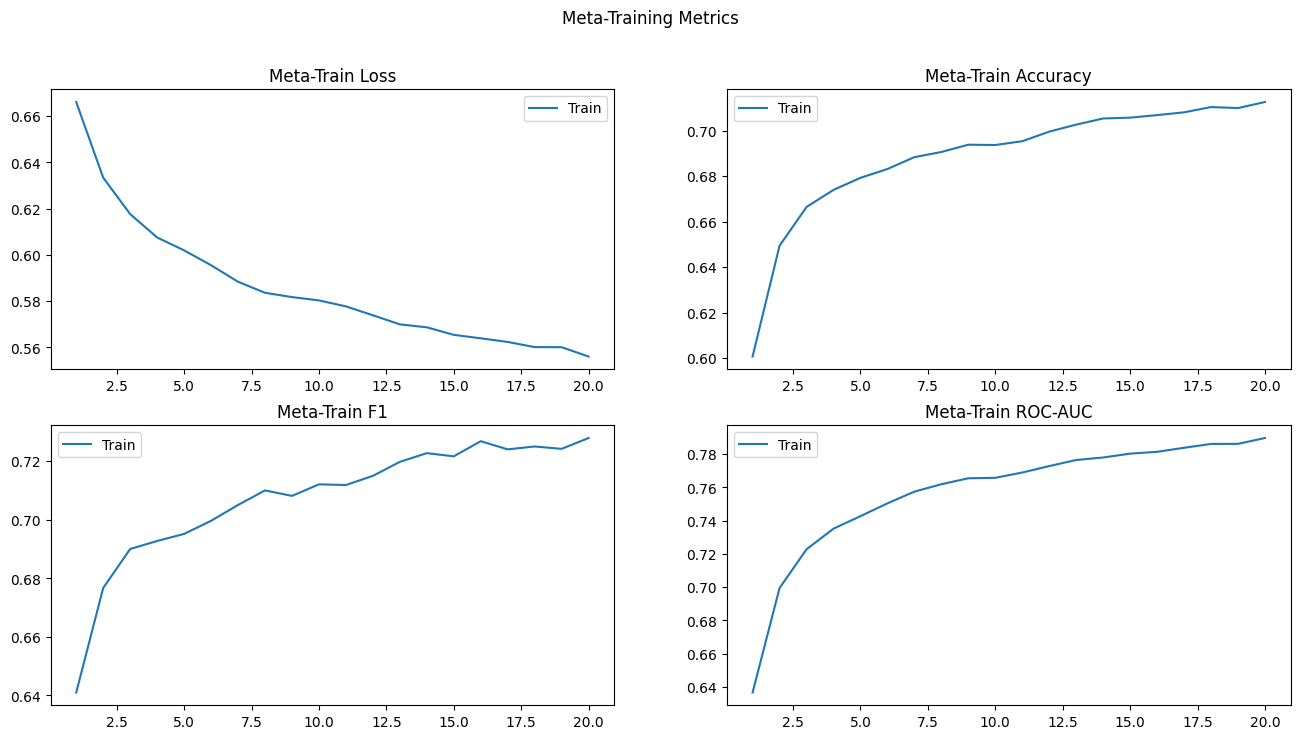

Meta-testing (adaptation curve)...


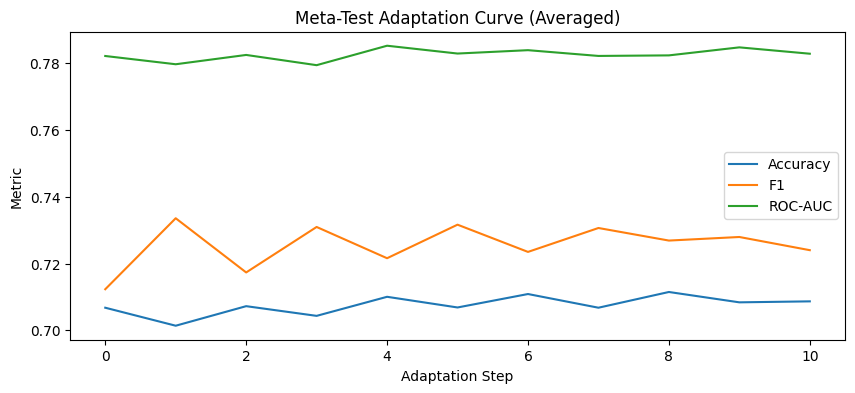

Meta-test final accuracy: 0.7087
Meta-test final F1: 0.7240
Meta-test final ROC-AUC: 0.7829


In [18]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print("Loading data...")
    train_dataset = HiggsDataset(CSV_PATH, n_samples=N_TRAIN)
    test_dataset = HiggsDataset(CSV_PATH, n_samples=N_META_TEST, offset=N_TRAIN)
    print("Meta-training...")
    model, history = maml_meta_train(
        train_dataset, META_TRAIN_TASKS, META_SUPPORT, META_QUERY,
        META_INNER_STEPS, META_INNER_LR, META_OUTER_LR, N_EPOCHS, device
    )
    plot_metrics(history, title="Meta-Training Metrics")
    print("Meta-testing (adaptation curve)...")
    meta_adaptation_curve(model, test_dataset, META_SUPPORT, META_QUERY, 10, META_INNER_LR, device, n_tasks=META_TEST_TASKS)